# Quantum Winter 2020 | TriQ | Stage_2 *#Fight_Noise*

Here we are! Final lap! Objective of this stage is to mitigate the noise and get a favourable output from the given quantum noise model. Request you to go through the notebook cells for the walkthrough of the same :)

## Objectives:
1. Import and implement QRAM from Q_4  
2. Import and implement Noise Model from Question
3. Mitigate noise method 1: Ignis default mitigation circuit array
4. Mitigate noise method 2: Analysis of individual qubit output and device a counter noise mitigation circuit. Inspiration: https://www.researchgate.net/publication/346933420_The_resilience_of_quantum_random_access_memory_to_generic_noise
5. Get TCR and fidelity output for the same

### Step 1: Import QRAM and required libraries

So here we start our code. We import pretty much the same code with a few cleanups and fixes to mitigate our noise model. Now the main objective is that since the main matrix A is gonna be stored in our QRAM, its sensitive to noise perturbations. Here we have 2 major sources of noise that can cause catastrophic results:  

1. Error in Data counter qubits which can completely change the state vector stored in the QRAM.
2. Error in the address counter qubits which can mess up the state vector of the address qubits in its superposition state or in the worst case destroy the super position.

### So here we go: 

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ,QuantumRegister, ClassicalRegister  
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from iqx import *
import numpy as np

# Importing noise model libraries
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


### Importing QRAM with matrix A

In [2]:
#Define_State_values
def zero(qc,data,address):
    return qc,data,address
def one(qc,data,address):
    qc.mct(address,data[0])
    return qc,data,address
def two(qc,data,address):
    qc.mct(address,data[1])
    return qc,data,address
def three(qc,data,address):
    qc.mct(address,data[0])
    qc.mct(address,data[1])
    return qc,data,address
def minus_one(qc,data,address):
    qc.mct(address,data[2])
    return qc,data,address
def minus_two(qc,data,address):
    qc.mct(address,data[0])
    qc.mct(address,data[2])
    return qc,data,address
def minus_three(qc,data,address):
    qc.mct(address,data[1])
    qc.mct(address,data[2])
    return qc,data,address

#Define State_assign_function
def States(val,data,qc,address):
    if (val == 0.0):
        return zero(qc,data,address)
    if (val == 1.0):
        return one(qc,data,address)
    if (val == 2.0):
        return two(qc,data,address)
    if (val == 3.0):
        return three(qc,data,address)
    if (val == -1.0):
        return minus_one(qc,data,address)
    if (val == -2.0):
        return minus_two(qc,data,address)
    if (val == -1.0):
        return minus_three(qc,data,address)


In [3]:
#Q_RAM (Max_Capacity = 2048 States @ 11 Qubit Address_Registers, 3 Data_Registers)
address = QuantumRegister(11, name = "address")
data = QuantumRegister(3, name = "data")
c = ClassicalRegister(11,name = "measurement")
qc = QuantumCircuit(address,data,c)

qc.h(address)
qc.barrier()

aa = np.ones(38) #central diag
bb = 1.0*np.ones(39) #upper_t diag
cc = -1.0*np.ones(38) #lower_t diag
A = np.diag(aa,-1) + np.diag(bb,0) + np.diag(cc,1) #Matrix A acc to hint
A[0,0]=3.0 #a41
A[-1,-1]=1 #b1
A[0,1]=-2.0 #c41

print(A) #debugging

def QRAM_11(A):
    for i in range(39): #Store a 41*41 Matrix
        for j in range(39):
            binary = f'{((i*10)+j):00000000011b}'
            if(binary[0] == '0'):
                qc.x(address[0])
            if(binary[1] == '0'):
                qc.x(address[1])
            if(binary[2] == '0'):
                qc.x(address[2])
            if(binary[3] == '0'):
                qc.x(address[3])
            if(binary[4] == '0'):
                qc.x(address[4])
            if(binary[5] == '0'):
                qc.x(address[5])
            if(binary[6] == '0'):
                qc.x(address[6])
            if(binary[7] == '0'):
                qc.x(address[7])
            if(binary[8] == '0'):
                qc.x(address[8])
            if(binary[8] == '0'):
                qc.x(address[8])
            if(binary[9] == '0'):
                qc.x(address[9])
            if(binary[10] == '0'):
                qc.x(address[10])

            States(A[i,j],data,qc,address)

            if(binary[0] == '0'):
                qc.x(address[0])
            if(binary[1] == '0'):
                qc.x(address[1])
            if(binary[2] == '0'):
                qc.x(address[2])
            if(binary[3] == '0'):
                qc.x(address[3])
            if(binary[4] == '0'):
                qc.x(address[4])
            if(binary[5] == '0'):
                qc.x(address[5])
            if(binary[6] == '0'):
                qc.x(address[6])
            if(binary[7] == '0'):
                qc.x(address[7])
            if(binary[8] == '0'):
                qc.x(address[8])
            if(binary[8] == '0'):
                qc.x(address[8])
            if(binary[9] == '0'):
                qc.x(address[9])
            if(binary[10] == '0'):
                qc.x(address[10])
                
            qc.barrier()

#call functions
QRAM_11(A)
#Oracle_PDE()
#Oracle_2_PDE()
#Counter_Oracle_2_PDE()
#Counter_Oracle_PDE()
QRAM_11(A)
#Compare_PDE()

qc.barrier()

#qc = qc.reverse_bits()
qc.measure(address,c)

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
print(count)

[[ 3. -2.  0. ...  0.  0.  0.]
 [ 1.  1. -1. ...  0.  0.  0.]
 [ 0.  1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  1.  1. -1.]
 [ 0.  0.  0. ...  0.  1.  1.]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


{'00000000000': 2, '00000000001': 4, '00000010000': 3, '00100000000': 7, '00100000001': 1, '00100000010': 5, '00100000011': 8, '00100000100': 4, '00100000101': 4, '00100000110': 8, '00100000111': 2, '00100001000': 2, '00100001001': 5, '00100001010': 7, '00100001011': 2, '00100001100': 5, '00100001101': 3, '00100001110': 3, '00100001111': 2, '00000010001': 3, '00100010000': 4, '00100010001': 4, '00100010010': 3, '00100010011': 6, '00100010100': 3, '00100010101': 6, '00100010110': 3, '00100010111': 1, '00100011000': 7, '00100011001': 2, '00100011010': 4, '00100011011': 5, '00100011100': 5, '00100011101': 6, '00100011110': 4, '00100011111': 6, '00000010010': 6, '00100100000': 3, '00100100001': 5, '00100100010': 3, '00100100011': 9, '00100100100': 3, '00100100101': 6, '00100100110': 2, '00100100111': 3, '00100101001': 4, '00100101010': 2, '00100101011': 1, '00100101100': 3, '00100101101': 6, '00100101110': 7, '00100101111': 5, '00000010011': 5, '00100110000': 2, '00100110001': 4, '00100110

In [4]:
print(result)

Result(backend_name='qasm_simulator', backend_version='0.7.1', qobj_id='5779329f-2ce4-4418-858d-a488ded0a916', job_id='dc0b3caf-ba2e-49b4-a766-ead950b69ee9', success=True, results=[ExperimentResult(shots=8000, success=True, meas_level=MeasLevel.CLASSIFIED, data=ExperimentResultData(counts={'0x0': 2, '0x1': 4, '0x10': 3, '0x100': 7, '0x101': 1, '0x102': 5, '0x103': 8, '0x104': 4, '0x105': 4, '0x106': 8, '0x107': 2, '0x108': 2, '0x109': 5, '0x10a': 7, '0x10b': 2, '0x10c': 5, '0x10d': 3, '0x10e': 3, '0x10f': 2, '0x11': 3, '0x110': 4, '0x111': 4, '0x112': 3, '0x113': 6, '0x114': 3, '0x115': 6, '0x116': 3, '0x117': 1, '0x118': 7, '0x119': 2, '0x11a': 4, '0x11b': 5, '0x11c': 5, '0x11d': 6, '0x11e': 4, '0x11f': 6, '0x12': 6, '0x120': 3, '0x121': 5, '0x122': 3, '0x123': 9, '0x124': 3, '0x125': 6, '0x126': 2, '0x127': 3, '0x129': 4, '0x12a': 2, '0x12b': 1, '0x12c': 3, '0x12d': 6, '0x12e': 7, '0x12f': 5, '0x13': 5, '0x130': 2, '0x131': 4, '0x132': 3, '0x133': 1, '0x134': 6, '0x135': 6, '0x136': 

## Step 2: Plot Histogram

In order to know and visualize the result, a simple scoring metric just wont cut it. A histogram plot is a great way to actually look at the result and get some insights so as to where the noise might be most prominent or which part of the circuit to acutally probe into. Lets go!



In [5]:
plot_histogram(count,figsize = (400,400), bar_labels=False)

## Umm.....ok......
Ok this was unexpected.....or well maybe I did not expect it to be so teeny tiny. This plot is probably next to being useless even if I somehow manage to get a huge enough monitor to look at it. If I am gonna get such huge plots for 14 qubits, its pretty much not feasible to look at where the noise is most prominent or where I need to act to mitigate it. Main problem here is that there are 2048 unique values with none of the states that can be grouped hence we are getting way too many points. So lets simplify it a bit!

My next objective here is to atleast make a visualizing metric and convert the result into a visualizable graph which I can interpret it very well. Again TCA is a good enough metric but it doesnt really tell me where I might have went wrong so a visualization wont probably hurt :)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


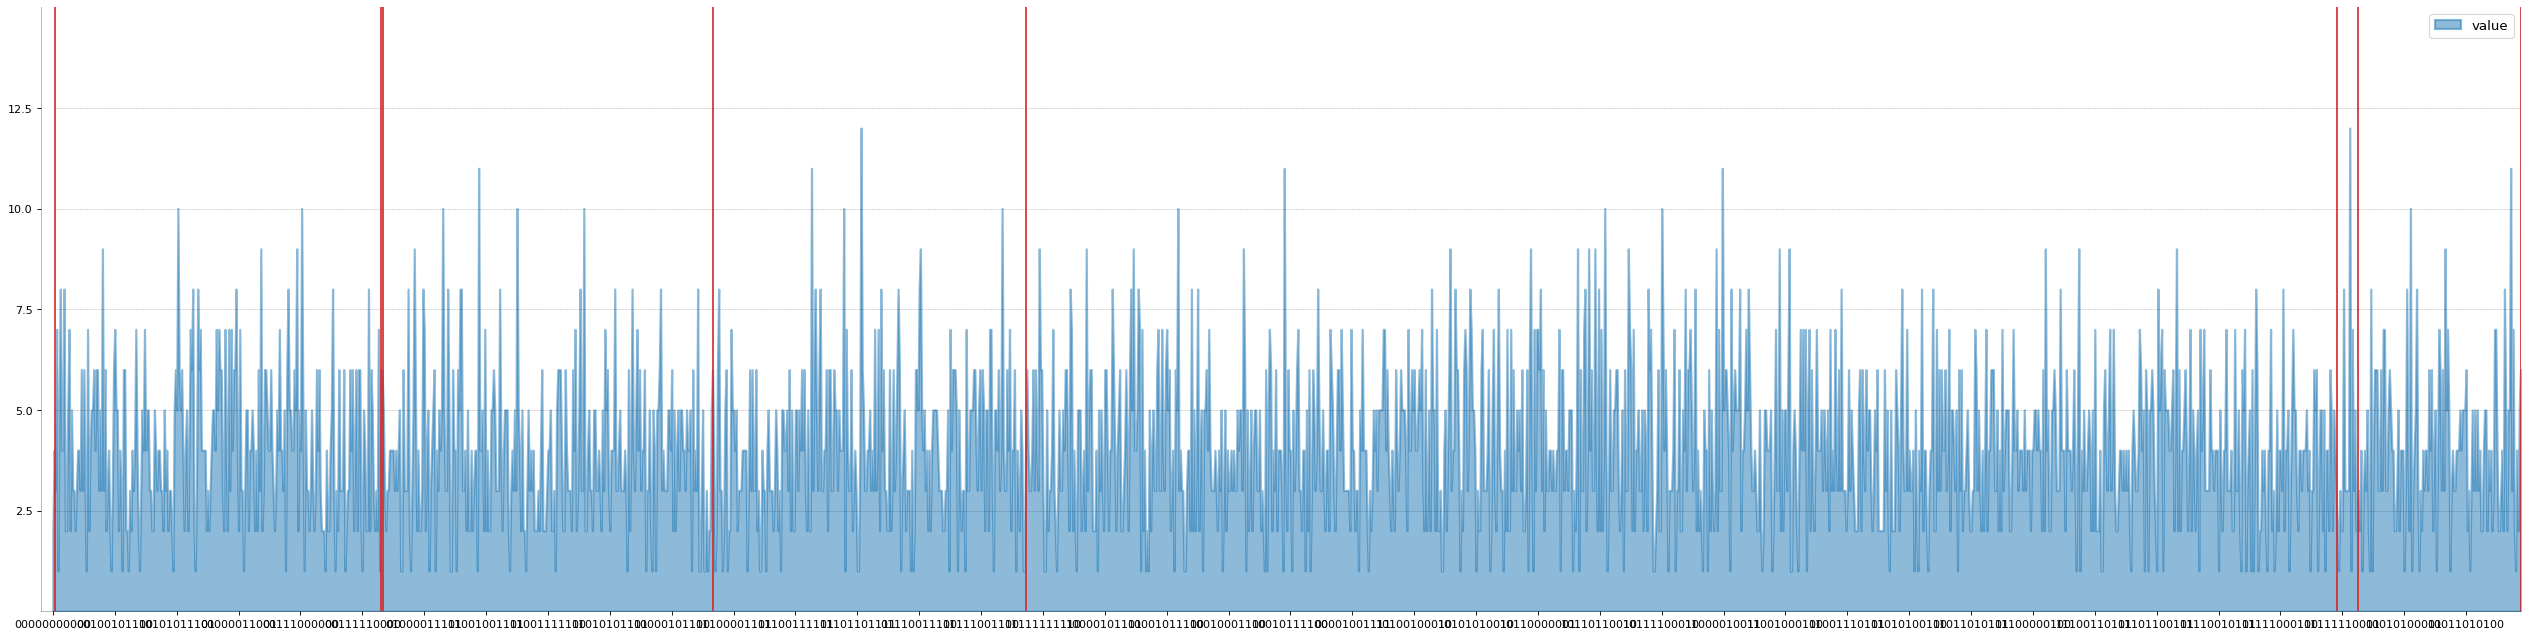

In [45]:
#Convert counts to list. Counts is in the form of qiskit object. Need to extract from result.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from IPython.display import Image
from IPython.core.display import HTML 

result_dict = result.data() #Convert result to dict
result_data = result_dict['counts'] #Remember, The result dict has only 1 indext i.e. counts
result_list = list(result_data.items()) #Convert data to list for plotting
length = len(result_list) #Store length of result
new_x = [None]*length
new_y = [None]*length
for i in range(0,length):
    new_x[i] = (f'{int((result_list[i][0]),0):00000000011b}') #Result is stored in binary string. Need to convert it into 11 digit binary string
    new_y[i] = result_list[i][1] #New Y i.e. value of binary string in tuple

#Plotting the Area chart. Here are some parameters I used
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      
columns = ['psavert', 'uempmed']

#Base plot. Can be visualized just by these two lines
fig, ax = plt.subplots(1, 1, figsize=(40,10), dpi= 80)
ax.fill_between(x=new_x, y1=new_y, label='value', alpha=0.5, color=mycolors[1], linewidth=2)

#Beautification
ax.set(ylim=[0, 15])
ax.legend(loc='best', fontsize=12)
plt.xticks(new_x[::50], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(2.5, 15.0, 2.5), fontsize=10, )
plt.xlim(-10, new_x[-1])

# Draw Tick lines  
for y in np.arange(2.5, 15.0, 2.5):    
    plt.hlines(y, xmin=0, xmax=len(new_x), colors='black', alpha=0.3, linestyles="--", lw=0.5)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)


#Vertical lines for dividing graph into qubits to identify error
xcoords = ['00000010000''00000000010', '00000000011', '00000001000','00000010000','00000100000','00000111111','00001111111','00011111111','00111111111','100000000000']
for xc in xcoords:
    plt.axvline(x = xc,color=mycolors[0])

plt.show()

# Much more managable....
After digging around and refreshing a bit of stats knowledge, an Area chart overlapped in an unstacked fasion looks to be the best bet for visualizing where things might have gone awry.  

So the main idea is to basically overlap the ideal graph and the graph obtained after applying noise model, traverse the vertical lines to identify where the problem might be. Something like this below:

![Unstacked_plot](https://i.ibb.co/TKPz8W6/Screenshot-75.png) 


# Now lets go bring up our noise model from the question!
Here we proceed to bring the noise model provided to us to solve. Goal is to implement it and the observe the resulting graph and take out next step to mitigate it!


In [46]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'cx', 'measure', 'reset', 'u2', 'u1']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Yay! Noise Model is in!

Noise model is finally inserted and initialised. Target is our main QRAM circuit "qc"

In [47]:
noisy_simulator = QasmSimulator(noise_model=noise_bit_flip)
job = execute(qc,noisy_simulator)
result_bit_flip = job.result()
counts_bit_flip = result_bit_flip.get_counts()
print(counts_bit_flip)
# Plot noisy output
plot_histogram(counts_bit_flip,figsize = (400,400), bar_labels=False)

KeyboardInterrupt: 

![Unstacked_plot](https://i.ibb.co/cxydqx2/Screenshot-76.png) 

# Ok..... whats happening?!    .\_.

This is not good.  

As soon as we apply the noise model, the whole kernel crashes! Multiple times at that! What might be the issue? Initial troubleshooting and fooling around with the code didnt help much. Perhaps try with something else? Lets try adding in the thermal noise model provided in the quesion....

In [48]:
# T1 and T2 values for qubits 0-3 As provided in Stage_2_Question
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u3', 'cx', 'measure', 'reset', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


In [49]:
# Run the noisy simulation
thermal_simulator = QasmSimulator(noise_model=noise_thermal)
job = execute(qc, thermal_simulator)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts()

# Plot noisy output
plot_histogram(counts_thermal,figsize = (400,400), bar_labels=False)

KeyboardInterrupt: 

# Sigh....Same story again....

The kernel crashes again. Everytime I add in a noise model it seems to not handle it well. What might be the issue???

![Unstacked_plot](https://i.ibb.co/hyXSXZv/Screenshot-77.png) 

# RAM RAM RAM......

So theres our culprit. After waiting for half and hour per run, I kept a real close watch on the RAM counter.
Turns out the kernel is running out of RAM and is just killing itself in the process. Now this can happen due to two reasons: 
1. Sustained usage of RAM over-limit
2. No of gates above 900 after transpilation
  
Now I am unaware about how the transpiling works in the background and what the settings are. After hours of trouble shooting and finding out work arounds, considering to splice the circuits or get rid of qubits and a few other crazy ideas, I decided to probe into the RAM part.

## But Vishal...I have seen RAM spikes upto 29 GB.... it doesnt crash then? Why now?

The only explaination I could come up with my limited knowledge is that this virtual environment allows for RAM spikes but not sustained loads.
I noticed that while running the job and getting counts, RAM usage spiked well over 50 GB but the kernel remained stable. Apparantly it spikes for like 10-20 seconds but comes down to normal. 

My circuit here has a sustained RAM usage load above the allocated 8GB. So I kept an eye on the counter and the RAM usage spiked up slowly 0.1GB per 6 seconds. Turns out after running a rough calculation on the amount of estimated RAM usage for the circuit by glancing through a few papers, it needs around 14GB or RAM to simulate it completely.

## Ok, So run locally then???

Running locally on a system with ample RAM can probably get me to simulate the entireity of 14 qubits here, but unfortunately my laptop has the same amount of RAM as that of the quota allocated. My room mates too had the same amount and since all 3 laptops were of different generation, I couldnt even add in one of their RAM sticks into mine :/

## So what next....?

Well that doesnt stop us to explore ignis exactly. Lets take a look at their circuit calibrator!

In [50]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
qr = QuantumRegister(11)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2,3,4,5,6,7,8,9,10], qr=qr, circlabel='mcal')
state_labels

['00000000000',
 '00000000001',
 '00000000010',
 '00000000011',
 '00000000100',
 '00000000101',
 '00000000110',
 '00000000111',
 '00000001000',
 '00000001001',
 '00000001010',
 '00000001011',
 '00000001100',
 '00000001101',
 '00000001110',
 '00000001111',
 '00000010000',
 '00000010001',
 '00000010010',
 '00000010011',
 '00000010100',
 '00000010101',
 '00000010110',
 '00000010111',
 '00000011000',
 '00000011001',
 '00000011010',
 '00000011011',
 '00000011100',
 '00000011101',
 '00000011110',
 '00000011111',
 '00000100000',
 '00000100001',
 '00000100010',
 '00000100011',
 '00000100100',
 '00000100101',
 '00000100110',
 '00000100111',
 '00000101000',
 '00000101001',
 '00000101010',
 '00000101011',
 '00000101100',
 '00000101101',
 '00000101110',
 '00000101111',
 '00000110000',
 '00000110001',
 '00000110010',
 '00000110011',
 '00000110100',
 '00000110101',
 '00000110110',
 '00000110111',
 '00000111000',
 '00000111001',
 '00000111010',
 '00000111011',
 '00000111100',
 '00000111101',
 '000001

In [51]:
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [52]:
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_thermal)
cal_results = job.result()

In [53]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=[0,1,2,3,4,5,6,7,8,9,10], circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1.    0.018 0.025 ... 0.    0.    0.   ]
 [0.    0.982 0.    ... 0.    0.    0.   ]
 [0.    0.    0.975 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.949 0.    0.027]
 [0.    0.    0.    ... 0.    0.944 0.022]
 [0.    0.    0.    ... 0.    0.    0.915]]


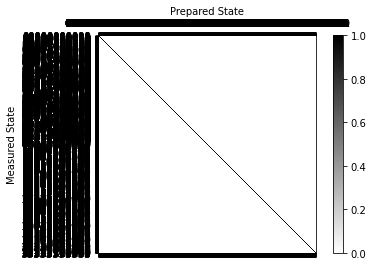

In [54]:
meas_fitter.plot_calibration()

# Theres the matrix! But whats the use of it?
Well, we did obtain the caliberation filter matrix for the noise model given. But we pretty much have nothing to apply it to. Since we cannot get the raw results after applying the 14 Qubit QRAM and noise model, we do not have anything to compare to, its pretty much nada at this point. :/ 

I do encourage you, if you are interested, setup a local environment with a device with around 32 GB RAM and run this circuit. Apply the caliberation filter and it might as well give some really favourable numbers!

# One final Hail Mary!
Well if the noise models arent gonna not play ball, that aint stopping us from using a REAL QUANTUM COMPUTER! Yes! We are well within the limit of the ibm_melbourne backend! Needed: 14 Qubits, Have: 16 Qubits! Lets go!

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_16_melbourne')
job_qc = execute(qc, backend=device, shots=1024)
print(job_qc.job_id)
from qiskit.tools.monitor import job_monitor
job_monitor(job_qc)
device_results = job_qc.result()

In [ ]:
plot_histogram(device_results.get_counts(qc),figsize = (40,40), bar_labels=False)

# * sigh * its not as easy as I thought...

Well, it definetly isnt as easy as I though and there are a lot of variables to look into before giving it to an actual QC. The transpiling itself took around 12 hours and still it didnt pass through the queue. I assume its taken down for maintainence but I probably wouldnt be able to get anything out by the deadline.

It was worth a shot though :p 

![Unstacked](https://i.ibb.co/MCgtQR8/Screenshot-78.png)

Legend says its still in queue :p


# Final remarks
Yes, this attempt has been a terrible failure, something even worse then the previous round since I couldnt even attempt the challenge properly and spent most of my time gruelling into why the simulator just didnt accept my circuit.

There is an absolutely long way to go and the path forward may be a bit hazy ahead with a lot of bumps and challenges. It has been an absolute treat to rack my brains, look into and work with concepts that I would have taken up a little bit later ahead in my learning path. It almost makes me feel that the path ahead has cleared up a little bit and has given me valuable insight into my next few steps ahead.

I am thankful to the organisers, judges and to each and every being who has helped in to organise this one of a kind event in India and special thanks to BosonQPSI and Quantum Computing India for picking up this awesome theme and piking my interest into Multi-Physics and Quantum computing as a whole. I have enrolled in a 9 week course on CFD and Multiphysics simulation which I intend to complete soon :) Thank you so much. It has been an absolute pleasure and I am sure I will be better geared up and intellectually equipped to take on the challenge next year ahead :)   

-TriQ | Vishal Bajpe